In [225]:
'''
This code generates a graph that shows how accessible a place is, utilizing the accessmap.io api. It produces a graph, 
the region that has a color closer to blue/purple is more accessible where the region that has a color closer to red/orange
is less accessible. Assume that the coordinate you put in is in the middle of the graph (this would be improved later).

RUN WITH PYTHON 3.5
'''

'''
RUNNING THE CODE REQUIRES 5 SIDEWALKOBSERVATIONS SHAPE FILES. 
https://data.seattle.gov/dataset/SidewalkObservations/q37p-ync7

IF IT THROWS 'error: object of type 'float' has no len()', IT MEANS THAT THE RADII YOU ENTERED WAS TOO LARGE FOR THE ORIGIN 
COORD  (i.e. there's a lake right next to origin coord, and the api can't find a path to the lake) OR THERE IS A BUG WITH 
ACCESSMAP API (sometimes a coordinate isn't wrapped with [], see the printout output)

OUR CODE DID REFERENCE TO OTHER PEOPLE'S CODE. SEE THE INLINE COMMENT ON THE WEBSITE WE CONSULTED 

'''
print()

In [226]:
import geopandas as gpd
import pandas as pd
import urllib.request as ur
import json
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import math
import sys
%matplotlib inline

In [227]:
'''
FIELDS WHERE YOU CAN PUT IN YOUR INPUT: change the origin coordinates and radius below (suggested <6 radii)

'''

# this is the default coord (seattle children's hospibal downtown). Change it if you want
origin_coord = [47.610464, -122.317982] 


# radius unit in km, in increasing order please
radius = [0.2, 0.4, 0.6, 0.8]
          
'''
these are the 8 x and y coordinates representing N, NE, E, SE, ..., all of them 1 km away, to be scaled 

'''
sqrt2 = math.sqrt(2)
conversion_coord = [[1, 0], [1/sqrt2, -1/sqrt2], [0, -1], [-1/sqrt2, -1/sqrt2], [-1, 0], [-1/sqrt2, 1/sqrt2], [0, 1], [1/sqrt2, 1/sqrt2]]


'''
only select a small region of points that have issues with that we need to compare to see if it matches out path (significantly reduces the number of comparisons)

'''
square = [[1,1], [1,-1], [-1,-1], [-1,1]]
list_of_corners = []
for k in range(0, len(square)):
    x = origin_coord[0] + square[k][0] * radius[len(radius) - 1] * 1.3 * 180 / (math.pi * 6367)
    y = origin_coord[1] + square[k][1] * radius[len(radius) - 1] * 1.3 * 180 / (math.pi * 6367 * math.cos(origin_coord[0]))
    list_of_corners.append([y, x]) #invert lat and long due to the way that api pass in lat, long
list_of_corners_polygon = []
list_of_corners_polygon.append([Polygon([(list_of_corners[0][0], list_of_corners[0][1]), (list_of_corners[1][0], list_of_corners[1][1]), (list_of_corners[2][0], list_of_corners[2][1]), (list_of_corners[3][0], list_of_corners[3][1])])])
dataframe2 = pd.DataFrame(list_of_corners_polygon)
dataframe2.columns = ['geometry']
gdf2 = gpd.GeoDataFrame(dataframe2.geometry)

all_data = gpd.read_file("SidewalkObservations.shp")
all_data = all_data[all_data.SURFACE_CO != ""]
issue_data = []

for region in gdf2.geometry:
    for point in all_data.geometry:
        if point.within(region) is True:
            issue_data.append([Point(point.x, point.y)]) #normal long, lat since this is the way we compare our data
            
dataframe3 = pd.DataFrame(issue_data)

dataframe3.columns = ['geometry']
issue_data = gpd.GeoDataFrame(dataframe3.geometry)

'''
counts the number of issues for each point from the origin

'''
issues_output = []

# for all the radius
for i in range(0, len(radius)):
    # for all the directions
    for j in range(0, len(conversion_coord)):
        x = origin_coord[0] + conversion_coord[j][0] * radius[i] * 180 / (math.pi * 6367)
        y = origin_coord[1] + conversion_coord[j][1] * radius[i] * 180 / (math.pi * 6367 * math.cos(origin_coord[0]))
        destination_coord = [x, y] 
   
        '''
        request this path to the coordinates caluclated from origin from api and convert to gpd format
        
        '''
        url = ur.urlopen('https://www.accessmap.io/api/v2/route.json?origin=' + str(origin_coord[0]) + '%2C' + str(origin_coord[1]) + '&destination=' + str(destination_coord[0]) + '%2C' + str(destination_coord[1]) + '')
        data = json.loads(url.read().decode())
        
        #https://stackoverflow.com/questions/21104592/json-to-pandas-dataframe
        coord = []
        coord.append([float(data['origin']['geometry']['coordinates'][0]), float(data['origin']['geometry']['coordinates'][1])])
        for result in data['routes'][0]['geometry']['coordinates']:
            coord.append(result)
        coord.append([float(data['destination']['geometry']['coordinates'][0]), float(data['destination']['geometry']['coordinates'][1])])
        try:
            df = pd.DataFrame(coord)
        except:
            print('error: object of type \'float\' has no len()')
            print(coord)
            print()
            print()
            print('see the top of the code for possible explanation on this exception')
            sys.exit()

        
        #https://gis.stackexchange.com/questions/174159/convert-a-pandas-dataframe-to-a-geodataframe
        geometry = [Point(xy) for xy in zip(df[0], df[1])]
        gdf = gpd.GeoDataFrame(geometry=geometry)
        
        # https://gis.stackexchange.com/questions/95670/how-to-create-a-shapely-linestring-from-two-points
        list_of_buffered_path = []
        for k in range(0, len(gdf) - 1):
            list_of_buffered_path.append(LineString([gdf.geometry[k], gdf.geometry[k+1]]).buffer(0.0001))
        dataframe = pd.DataFrame(list_of_buffered_path)
        dataframe.columns = ['geometry']
        
        gdf = gpd.GeoDataFrame(dataframe.geometry)
        
        '''
        count number of issues
        
        '''
        #http://michelleful.github.io/code-blog/2015/04/29/geopandas-manipulation/

        count = 0
        for point in issue_data.geometry:
            for region in gdf.geometry:
                if point.within(region) is True: 
                    count += 1
                    break
                    
        
        for region in gdf.geometry:        
            if Point(origin_coord[0], origin_coord[1]).within(region):
                print('hi2')
                    
        issues_output.append([destination_coord[0], destination_coord[1], count])
        print('finish counting', str(j + 1 + i * 8),'out of', str(len(radius) * 8), 'issues identified =', str(count))
        
print(issues_output)

finish counting 1 out of 32 issues identified = 2
finish counting 2 out of 32 issues identified = 0
finish counting 3 out of 32 issues identified = 2
finish counting 4 out of 32 issues identified = 2
finish counting 5 out of 32 issues identified = 7
finish counting 6 out of 32 issues identified = 12
finish counting 7 out of 32 issues identified = 3
finish counting 8 out of 32 issues identified = 3
finish counting 9 out of 32 issues identified = 8
finish counting 10 out of 32 issues identified = 3
finish counting 11 out of 32 issues identified = 7
finish counting 12 out of 32 issues identified = 8
finish counting 13 out of 32 issues identified = 9
finish counting 14 out of 32 issues identified = 18
finish counting 15 out of 32 issues identified = 13
finish counting 16 out of 32 issues identified = 6
finish counting 17 out of 32 issues identified = 8
finish counting 18 out of 32 issues identified = 9
finish counting 19 out of 32 issues identified = 9
finish counting 20 out of 32 issues i

[0    POLYGON ((47.60537347269018 -122.323740906259,...
dtype: object, 0    POLYGON ((47.60919136817255 -122.3194217265648...
dtype: object, 0    POLYGON ((47.6086642268097 -122.317982, 47.614...
dtype: object, 0    POLYGON ((47.6122637731903 -122.317982, 47.611...
dtype: object]
0


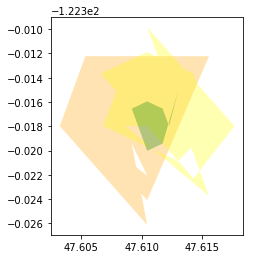

In [228]:
#http://geopandas.org/set_operations.html

'''
below code is for graphing given the number of issues at each coordinate

'''

# change the step size if needed, increasing order please 
issues_count = [0, 5, 10, 15, 20, 25]
issues_count.sort(reverse=True)
#issues_count = 0;
polygons = []
numOfCoords = 0
polygon_list = []
#issues_output = [[47.66569243297574, -122.322037, 1], [47.66437457956864, -122.31833357911476, 5], [47.661193, -122.31679957195693, 6], [47.65801142043136, -122.31833357911476, 1], [47.656693567024256, -122.322037, 11], [47.65801142043136, -122.32574042088523, 16], [47.661193, -122.32727442804305, 13], [47.66437457956864, -122.32574042088523, 56], [47.67019186595148, -122.322037, 4], [47.66755615913728, -122.31463015822955, 4], [47.661193, -122.31156214391387, 8], [47.65482984086272, -122.31463015822955, 16], [47.652194134048514, -122.322037, 15], [47.65482984086272, -122.32944384177044, 20], [47.661193, -122.33251185608611, 18], [47.66755615913728, -122.32944384177044, 61], [47.67469129892722, -122.322037, 5], [47.67073773870592, -122.31092673734432, 34], [47.661193, -122.30632471587082, 15], [47.65164826129408, -122.31092673734432, 12], [47.64769470107277, -122.322037, 23], [47.65164826129408, -122.33314726265567, 31], [47.661193, -122.33774928412917, 20], [47.67073773870592, -122.33314726265567, 29]]
#issues_output = [[47.6163717731903, -122.346023, 5], [47.61584463182746, -122.3445801257386, 3], [47.614572, -122.34398246765073, 0], [47.61329936817255, -122.3445801257386, 0], [47.6127722268097, -122.346023, 0], [47.61329936817255, -122.3474658742614, 5], [47.614572, -122.34806353234927, 1], [47.61584463182746, -122.3474658742614, 1], [47.618171546380594, -122.346023, 5], [47.61711726365491, -122.3431372514772, 6], [47.614572, -122.34194193530145, 3], [47.61202673634509, -122.3431372514772, 4], [47.61097245361941, -122.346023, 6], [47.61202673634509, -122.3489087485228, 6], [47.614572, -122.35010406469856, 4], [47.61711726365491, -122.3489087485228, 8], [47.619971319570894, -122.346023, 19], [47.61838989548237, -122.3416943772158, 12], [47.614572, -122.33990140295218, 6], [47.61075410451763, -122.3416943772158, 0], [47.60917268042911, -122.346023, 25], [47.61075410451763, -122.3503516227842, 23], [47.614572, -122.35214459704783, 4], [47.61838989548237, -122.3503516227842, 12], [47.621771092761186, -122.346023, 22], [47.61966252730983, -122.34025150295439, 10], [47.614572, -122.33786087060291, 9], [47.60948147269018, -122.34025150295439, 9], [47.60737290723882, -122.346023, 25], [47.60948147269018, -122.35179449704562, 23], [47.614572, -122.3541851293971, 22], [47.61966252730983, -122.35179449704562, 6], [47.623570865951486, -122.346023, 19], [47.62093515913728, -122.33880862869299, 11], [47.614572, -122.33582033825364, 7], [47.60820884086272, -122.33880862869299, 9], [47.60557313404852, -122.346023, 25], [47.60820884086272, -122.35323737130702, 23], [47.614572, -122.35622566174636, 23], [47.62093515913728, -122.35323737130702, 9]]
# change the graph colors if needed, include at least 1 color
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

'''
A way of sorting the coordinates. Found that the other way below is better.

'''
# while issues_output is not None:
#     if len(polygon_list) > 2:
#         polygon_list = []
#     for issue in issues_output:
#         if issue[2] is issues_count:
#             polygon_list.append((issue[0], issue[1]))
#     issues_output = [x for x in issues_output if issue[2] is not issues_count]
#     if len(polygon_list) > 2 or len(issues_output) < 3:
#         if len(issues_output) < 3:
#             for issue in issues_output:
#                 polygon_list.append((issue[0], issue[1]))
#             issues_output = None
#             break
#         polygons.append(gpd.GeoSeries([Polygon(polygon_list)]))
#     issues_count += 1


'''
sort all the coordinates into different groups based on their issues

'''
saved_count = 0
for count in issues_count:
    # only make a new list if the length of last list >= 3
    if numOfCoords is 0 or numOfCoords > 2:
        numOfCoords = 0
        polygon_list = []
    for issue in issues_output:
        if issue[2] >= count:
            polygon_list.append((issue[0], issue[1]))
            numOfCoords += 1
    issues_output = [x for x in issues_output if not x[2] >= count]
    # only make a new polygon if the number of coordinates >= 3
    if numOfCoords > 2:
        if len(issues_output) < 3:
            for issue in issues_output:
                polygon_list.append((issue[0], issue[1]))
        polygons.append(gpd.GeoSeries([Polygon(polygon_list)]))
        if len(issues_output) < 3:
            saved_count = count
            break
print(polygons)

'''
graph out each group of polygons and stack them on top of each other

'''
print(saved_count)
#https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure
gdf = gpd.GeoDataFrame(polygons[0])
gdf.columns = ['geometry']
ax = gdf.plot(color=colors[int(saved_count / 5)])
for i in range(1, len(polygons)):
    gdf = gpd.GeoDataFrame(polygons[i])    
    gdf.columns = ['geometry']
    ax = gdf.plot(ax=ax, color=colors[int(saved_count / 5 + i)], alpha=0.3)
ax

